# TP 1 - Naive Bayes

El siguiente trabajo práctico consta de dos ejercicios relacionados con el primer modulo visto en clase.

Fecha de entrega: Domingo 4 de abril 23:59 hs

Fecha de defensa: Lunes 5 de abril en horario de clase

# **Para ambos ejercicios desarrollar el código propio del clasificador**

Se pueden utilizar librerias para la etapa de limpieza de los datos. Para el clasificador propiamente dicho, tiene que ser implementado completamente. Pueden basarse en notebooks vistas en clase u otros materiales, pero es requisito que entiendan cómo funciona el código que utilicen.

Por último, se recomienda validar el funcionamiento de los mismos utilizando algún clasificador de una librería como Sklear

---
## Librerías

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from nltk.corpus import stopwords
import nltk
import string
import seaborn as sns
nltk.download('stopwords')

stop = stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Acer\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


---
## Ejercicio 1

Realizar un clasificador de noticias utilizando el conjunto de datos de _**fetch_20newsgroups**_ de Sklearn. A continuación, encontrarán el código para poder obtener el dataset.


Recordar elegir una métrica para medir el desempeño del modelo y validar los resultados. 

Explicar paso a paso que es lo que se va desarrollando.

**Incluir una explicación sobre Laplacian smoothing y para qué se utiliza** (evaluar su aplicación en la resolución de la consigna)

---
**Describiendo el dataset**
- **data:** mensajes. Hay 11314 datos 
- **filenames:** dirección de los mensajes
- **target_names:** total de clases posibles
- **target:** la clase a la que pertenece cada mensaje

**Clases**
- 'alt.atheism',
- 'comp.graphics',
- 'comp.os.ms-windows.misc',
- 'comp.sys.ibm.pc.hardware',
- 'comp.sys.mac.hardware',
- 'comp.windows.x',
- 'misc.forsale',
- 'rec.autos',
- 'rec.motorcycles',
- 'rec.sport.baseball',
- 'rec.sport.hockey',
- 'sci.crypt',
- 'sci.electronics',
- 'sci.med',
- 'sci.space',
- 'soc.religion.christian',
- 'talk.politics.guns',
- 'talk.politics.mideast',
- 'talk.politics.misc',
- 'talk.religion.misc'


rec.autos: 594
comp.sys.mac.hardware: 578
comp.graphics: 584
sci.space: 593
talk.politics.guns: 546
sci.med: 594
comp.sys.ibm.pc.hardware: 590
comp.os.ms-windows.misc: 591
rec.motorcycles: 598
talk.religion.misc: 377
misc.forsale: 585
alt.atheism: 480
sci.electronics: 591
comp.windows.x: 593
rec.sport.hockey: 600
rec.sport.baseball: 597
soc.religion.christian: 599
talk.politics.mideast: 564
talk.politics.misc: 465
sci.crypt: 595


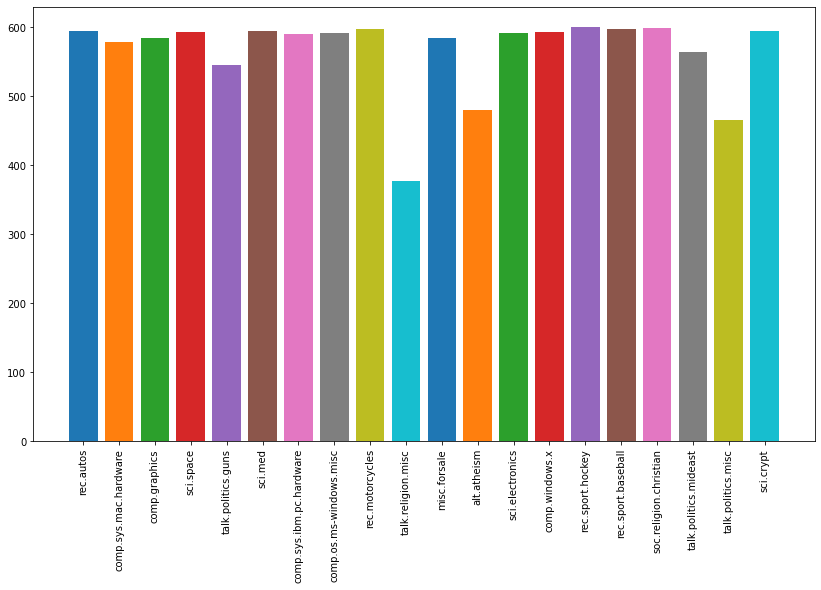

In [2]:
#Cargando dataset - training data
from sklearn.datasets import fetch_20newsgroups

training = fetch_20newsgroups(subset='train', shuffle=True, remove=('footers'))
categories = training.pop('target_names')
del training['DESCR'], training['filenames']

df = pd.DataFrame(training)

plt.figure(figsize=(14, 8))
for i in df['target'].unique():
    print('%s: %i'%(categories[i], (df['target']==i).sum()))
    plt.bar(categories[i], (df['target']==i).sum())
    plt.xticks(rotation='vertical')


In [3]:
import random
random.seed(10) # Para reproducción
for _ in range (2):
    pos = random.randint(0, 11313)
    print(df['data'][pos])
    print('Target: %s'%categories[df['target'][pos]])
    print('*'*60)

From: bil@okcforum.osrhe.edu (Bill Conner)
Subject: Re: islamic authority over women
Nntp-Posting-Host: okcforum.osrhe.edu
Organization: Okcforum Unix Users Group
X-Newsreader: TIN [version 1.1 PL9]
Lines: 8

Keith M. Ryan (kmr4@po.CWRU.edu) wrote:

: 	Nice cop out bill.

I'm sure you're right, but I have no idea to what you refer. Would you
mind explaining how I copped out?
Target: alt.atheism
************************************************************
From: enzo@research.canon.oz.au (Enzo Liguori)
Subject: Vandalizing the sky.
Organization: Canon Information Systems Research Australia
Lines: 38

From the article "What's New" Apr-16-93 in sci.physics.research:

........
WHAT'S NEW (in my opinion), Friday, 16 April 1993  Washington, DC

1. SPACE BILLBOARDS! IS THIS ONE THE "SPINOFFS" WE WERE PROMISED?
In 1950, science fiction writer Robert Heinlein published "The
Man Who Sold the Moon," which involved a dispute over the sale of
rights to the Moon for use as billboard. NASA has taken t

### Limpieza de Datos

Se  va a separar el **mensaje** y el **header**. Luego, se extrae la información de _**Subject:**_ y _**Organization:**_

In [4]:
import re
import string
from emot.emo_unicode import EMOTICONS
from textblob import TextBlob

def get_info(text,subheader):
    x = text.split(subheader)[-1].split('\n')[0].split(',')[0]
    while len(x.split(':'))>1:
        x = x.split(':')[1]
    return x

def reduce(text):
    data = text.lower().split('\n\n')
    new_data = ' '.join(data[1:-1])
    header = data[0]
    subject = get_info(header, 'subject:')
    organization = get_info(header, 'organization:')
    return '\n'.join([subject, organization, new_data])

def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)

def remove_emoticons(text):
    emoticon_pattern = re.compile(u'(' + u'|'.join(k for k in EMOTICONS) + u')')
    return emoticon_pattern.sub(r'', text)

def clean(text):
    # Reduce text length
    text = reduce(text)
#     # Remove text in square brackets
#     text = re.sub('\[.*?\]', '', text)
#     # Remove text in parenthesis
#     text = re.sub('\(.*?\)', '', text)
#     # Remove text in brackets
#     text = re.sub('\{.*?\}', '', text)
    # Remove punctuation
    text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text)
    # Remove stopwords
    text = " ".join(x for x in text.split() if x not in stop)
    # Remove htmls
    text = remove_html(text)
    # Remove words that contains numbers
    text = re.sub('\w*\d\w*', '', text)
    # Remove numbers
    text = " ".join(x for x in text.split() if not x.isdigit())
    # Remove extra \n
    text = re.sub('\n', '', text)
    # Remove extra space
    text = re.sub('  ', ' ', text)
    # Remove emoticon
    text = remove_emoticons(text)
    # Correct spelling
#     text =str(TextBlob(text).correct())
    return text

df['data'] = df['data'].apply(clean)

random.seed(10) # Para reproducción
for _ in range (2):
    pos = random.randint(0, 11313)
    print(df['data'][pos])
    print('Target: %s'%categories[df['target'][pos]])
    print('*'*60)

islamic authority women okcforum unix users group keith ryan po cwru edu wrote nice cop bill
Target: alt.atheism
************************************************************
vandalizing sky canon information systems research australia article new apr sci physics research new opinion friday april washington dc space billboards one spinoffs promised science fiction writer robert heinlein published man sold moon involved dispute sale rights moon use billboard nasa taken firsteps toward hideous vision future observers startled spring nasa launch vehicle arrived pad schwarzenegger painted huge block letters side booster rockets space marketing inc arranged ad promote arnold latest movie space marketing working university colorado livermore engineers plan place mile long inflatable billboard low earth orbit nasa would provide contractual launch services however since nasa bases charge seriously flawed cost estimates wn mar taxpayers would bear expense may look like environmental vandalism mi

In [5]:
freq = pd.Series(' '.join(df['data']).split()).value_counts()
print('total de palabras: %i'%len(freq))
print(freq.sum())
print(freq[:60])
print('*'*20)
print(freq[-60:])


total de palabras: 61856
1299480
edu            8396
writes         7261
one            7104
would          7012
article        6124
com            4928
people         4850
like           4524
university     4156
get            3896
know           3885
also           3505
think          3403
use            3388
time           3289
new            3033
good           2826
could          2784
well           2730
even           2647
may            2545
two            2487
see            2441
many           2431
us             2412
first          2387
god            2379
system         2328
way            2312
much           2273
make           2241
right          2235
x              2144
say            2092
want           1987
used           1981
said           1961
need           1910
anyone         1814
problem        1801
something      1766
c              1756
really         1699
state          1693
since          1685
e              1679
work           1652
go             1631
back   

In [6]:
stop_words = set(stopwords.words('english'))

add_word1 = freq[freq<10].index.to_list()
add_word2 = ['us', 'x', 'c', 'e', 'may', 'one', 'two']
add_word3 = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'set', 'oct', 'nov', 'dec']

stop_added = stop_words.union(add_word1)
stop_added = stop_added.union(add_word2)
stop_added = stop_added.union(add_word3)

df.data =df.data.apply(lambda x: " ".join(x for x in x.split() if x not in stop_added))

from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
vectors = vectorizer.fit_transform(df.data)
vectors.shape

(11314, 13441)

Cantidad: 7532
rec.autos: 396
comp.windows.x: 395
alt.atheism: 319
talk.politics.mideast: 376
talk.religion.misc: 251
sci.med: 396
soc.religion.christian: 398
comp.graphics: 389
comp.os.ms-windows.misc: 394
rec.motorcycles: 398
comp.sys.mac.hardware: 385
misc.forsale: 390
talk.politics.guns: 364
sci.space: 394
comp.sys.ibm.pc.hardware: 392
sci.crypt: 396
rec.sport.baseball: 397
rec.sport.hockey: 399
talk.politics.misc: 310
sci.electronics: 393
(7532, 13441)


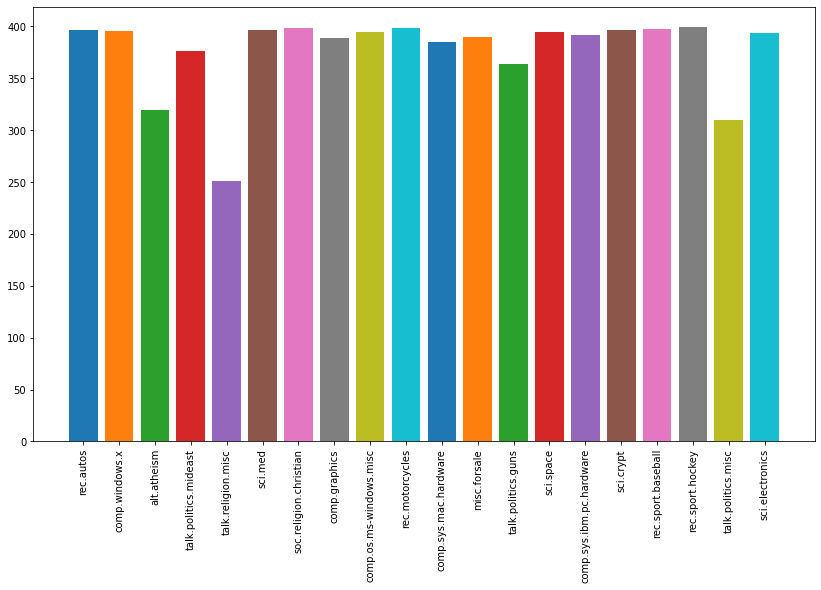

In [7]:
testing = fetch_20newsgroups(subset='test', shuffle=True, remove=('footers'))
del testing['DESCR'], testing['filenames'], testing['target_names']

test = pd.DataFrame(testing)
print('Cantidad: %i'%len(test))
plt.figure(figsize=(14, 8))
for i in test['target'].unique():
    print('%s: %i'%(categories[i], (test['target']==i).sum()))
    plt.bar(categories[i], (test['target']==i).sum())
    plt.xticks(rotation='vertical')

# Limpieza del test set
test['data'] = test['data'].apply(clean)

test.data =test.data.apply(lambda x: " ".join(x for x in x.split() if x not in stop_added))
vectors_test = vectorizer.transform(test.data)
print(vectors_test.shape)

In [8]:
test.head()

,data,target
0,need info bonneville university buffalo,7
1,face familiar format face seeing folks headers...,5
2,strong weak atheism mantis consultants mac cc ...,0
3,saudi human rights group u arizona cs dept art...,17
4,years sgi article st andrews ac uk st andrews ...,19


### Sin Laplacian smoothing

In [9]:
BN_probs = []
perc_categories = []
for i in df.target.unique():
    new = vectors.toarray()[df.target==i]
    probs = new.sum(axis=0)/new.sum(),
    perc = (df.target==i).mean()
    BN_probs.append(probs)
    perc_categories.append(perc)
    
BN_probs = np.array(BN_probs)
perc_categories = np.array([perc_categories]).T

print(BN_probs.shape)
print(perc_categories.shape)

(20, 1, 13441)
(20, 1)


Training: 13.90
Testing: 6.88


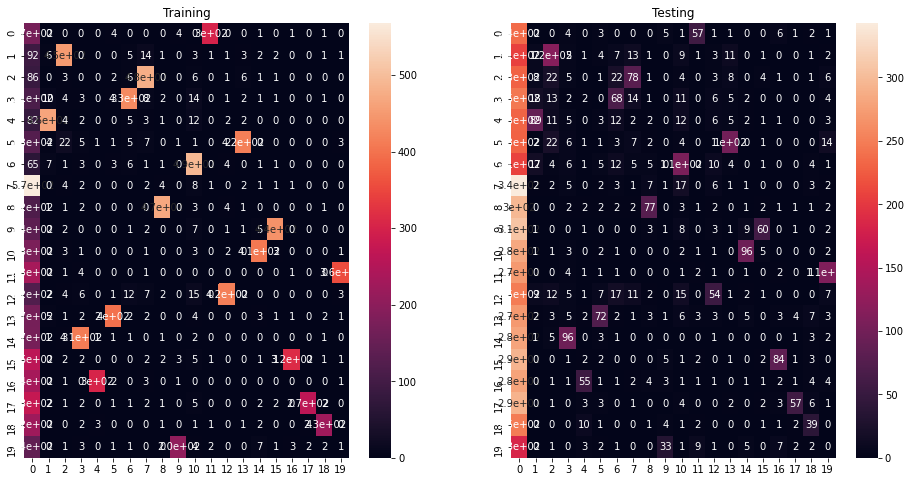

In [10]:
from sklearn import metrics
import seaborn as sns
def myBN(vectors, y_trues, BN_probs, perc_categories):
    results = []
#     print(vectors.shape)
#     print(y_trues)
    for case, y_true in zip(vectors, y_trues):
        probs = ((BN_probs**case).prod(axis=2))*perc_categories
        y_pred = np.argmax(probs)
        results.append(y_pred)
    return np.array(results)
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
ax[0].set_title('Training')
ax[1].set_title('Testing')
## Training
y_pred = myBN(vectors.toarray(), df.target, BN_probs, perc_categories)
res = y_pred==df.target
CM = metrics.confusion_matrix(df.target, y_pred)
sns.heatmap(CM, ax=ax[0])
print('Training: %.2f'%(res.mean()*100))

## Testing
y_pred = myBN(vectors_test.toarray(), test.target, BN_probs, perc_categories)
res = y_pred==test.target
CM = metrics.confusion_matrix(test.target, y_pred)
sns.heatmap(CM, ax=ax[1])
print('Testing: %.2f'%(res.mean()*100))


### Con Laplacian smoothing

In [11]:
BN_probs = []
perc_categories = []
for i in df.target.unique():
    new = vectors.toarray()[df.target==i] + 1
    probs = new.sum(axis=0)/new.sum(),
    perc = (df.target==i).mean()
    BN_probs.append(probs)
    perc_categories.append(perc)
    
BN_probs = np.array(BN_probs)
perc_categories = np.array([perc_categories]).T

print(BN_probs.shape)
print(perc_categories.shape)

(20, 1, 13441)
(20, 1)


Training: 7.24
Testing: 6.45


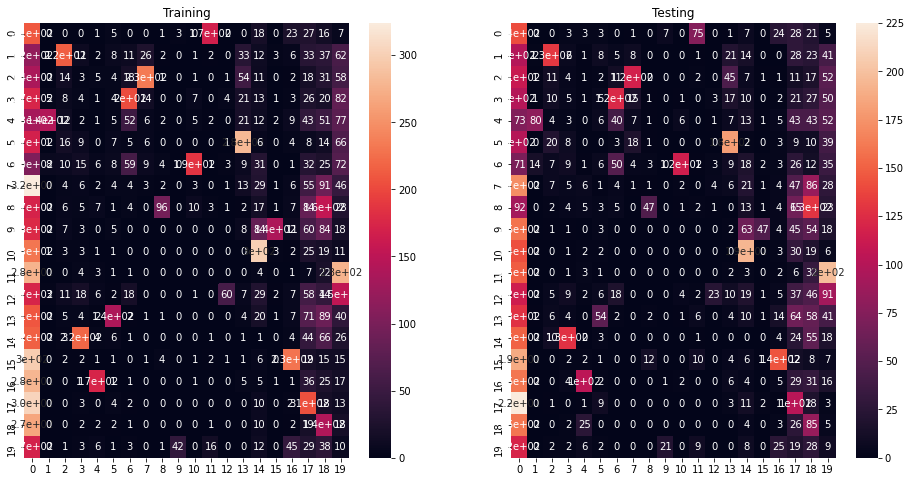

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
ax[0].set_title('Training')
ax[1].set_title('Testing')
## Training
y_pred = myBN(vectors.toarray(), df.target, BN_probs, perc_categories)
res = y_pred==df.target
CM = metrics.confusion_matrix(df.target, y_pred)
sns.heatmap(CM, ax=ax[0])
print('Training: %.2f'%(res.mean()*100))

## Testing
y_pred = myBN(vectors_test.toarray(), test.target, BN_probs, perc_categories)
res = y_pred==test.target
CM = metrics.confusion_matrix(test.target, y_pred)
sns.heatmap(CM, ax=ax[1])
print('Testing: %.2f'%(res.mean()*100))

---
## Ejercicio 2

A partir del Pima Indians Diabetes Dataset predecir la aparición de diabetes basado en diferentes valores diagnósticos.

Este conjunto de datos es del  National Institute of Diabetes and Digestive and Kidney Diseases originalmente. 

Posee ciertas limitaciones para la selección de los pacientes a partir de una base de datos más grande. En particular, son todos pacientes femeninos de al menos 21 años de edad de herencia Pima Indian.

Las variables:


*   Pregnancies (embarazos): Número de embarazos
*   Glucose: Concentración de glucosa en sangre a 2 horas de una prueba de tolerancia de glucosa oral.
*   BloodPresure (Presión sanguinea): Presión diastólica (mm Hg)
*   SkinThickness: Tamaño del pliege de la piel del triceps
*   Insulin: Insulina en sangre a 2 horas (mu U/ml)
*   BMI: Indice de masa corporal (peso en kg / (altura en metros)^2)
*   DiabetesPedigreeFunction: Una función que estima el likelihood de tener diabetes dado el historial familiar
*   Age: Edad (años)
*   Outcome: Variable 0 o 1 (0 no posee diabtes, 1 posee diabetes)

Este ejercicio consta de dos partes:



1.   Realizar un EDA completo de este dataset incluyendo: cantidad de valores nulos de las variables, número de personas para cada clase, análisis de distribuciones de las variables (por ejemplo se pueden usar histogramas), análisis de outliers y correlación entre variables. Recordar explicar las diferentes decisiones que se vayan tomando respecto de la limpieza y calidad de los datos
2.   Generar un clasificador utilizando las variables que se consideren óptimas. Recordar elegir una métrica para medir el desempeño del modelo y validar los resultados. 




In [86]:
df = pd.read_csv('diabetes.csv')

## Análisis de datos

In [87]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [91]:
(df[['Glucose', 'BloodPressure', 'SkinThickness','Insulin', 'BMI']]==0).mean()*100

Glucose           0.651042
BloodPressure     4.557292
SkinThickness    29.557292
Insulin          48.697917
BMI               1.432292
dtype: float64

In [45]:
for i in df.keys():
    print('%s tiene %i unicos valores'%(i, len(df[i].unique())))


Pregnancies tiene 17 unicos valores
Glucose tiene 136 unicos valores
BloodPressure tiene 47 unicos valores
SkinThickness tiene 51 unicos valores
Insulin tiene 186 unicos valores
BMI tiene 248 unicos valores
DiabetesPedigreeFunction tiene 517 unicos valores
Age tiene 52 unicos valores
Outcome tiene 2 unicos valores


Se va a descartar la **Insulina** ya que tiene casi 50% de los datos no registrados

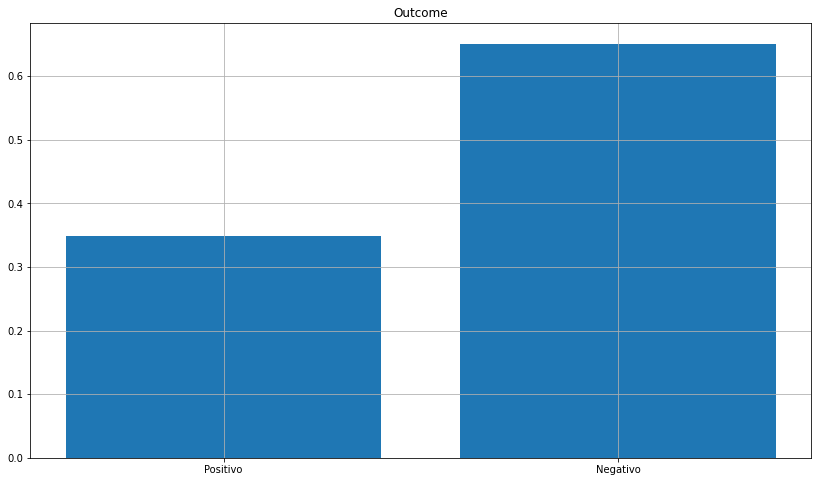

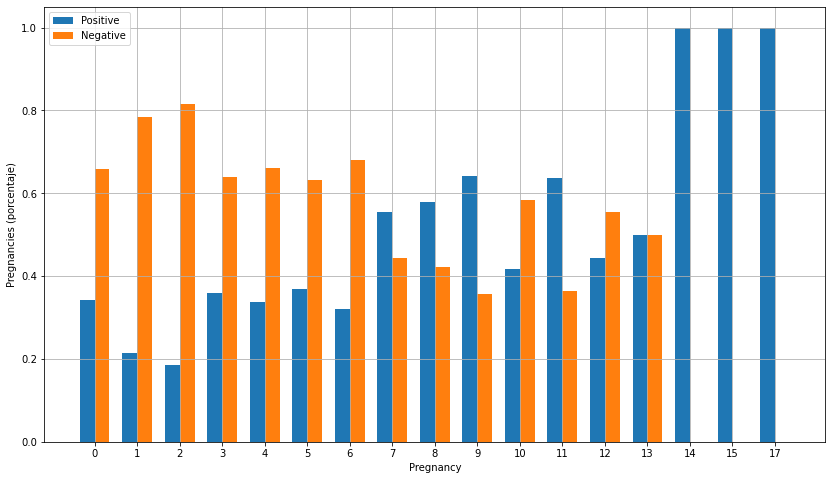

In [63]:
def myBar(data, column):
    freq1 = data[[column, 'Outcome']].groupby(by=[column]).mean()
    labels = freq1.index.tolist()
    x = np.arange(len(labels))
    width = 0.35
    y = np.array(freq1['Outcome'])

    fig, ax = plt.subplots(1,1, figsize=(14,8))
    rects1 = ax.bar(x - width/2, y, width, label='Positive')
    rects2 = ax.bar(x + width/2, 1-y, width, label='Negative')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel(column+' (porcentaje)')
    ax.set_xlabel('Pregnancy')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()
    ax.grid(True)
    plt.show()
    
cantidad = df['Outcome'].mean()
plt.figure(figsize=(14,8))
plt.bar(['Positivo', 'Negativo'], [cantidad, 1-cantidad])
plt.title('Outcome')
plt.grid(1)
plt.show()

myBar(df, 'Pregnancies')


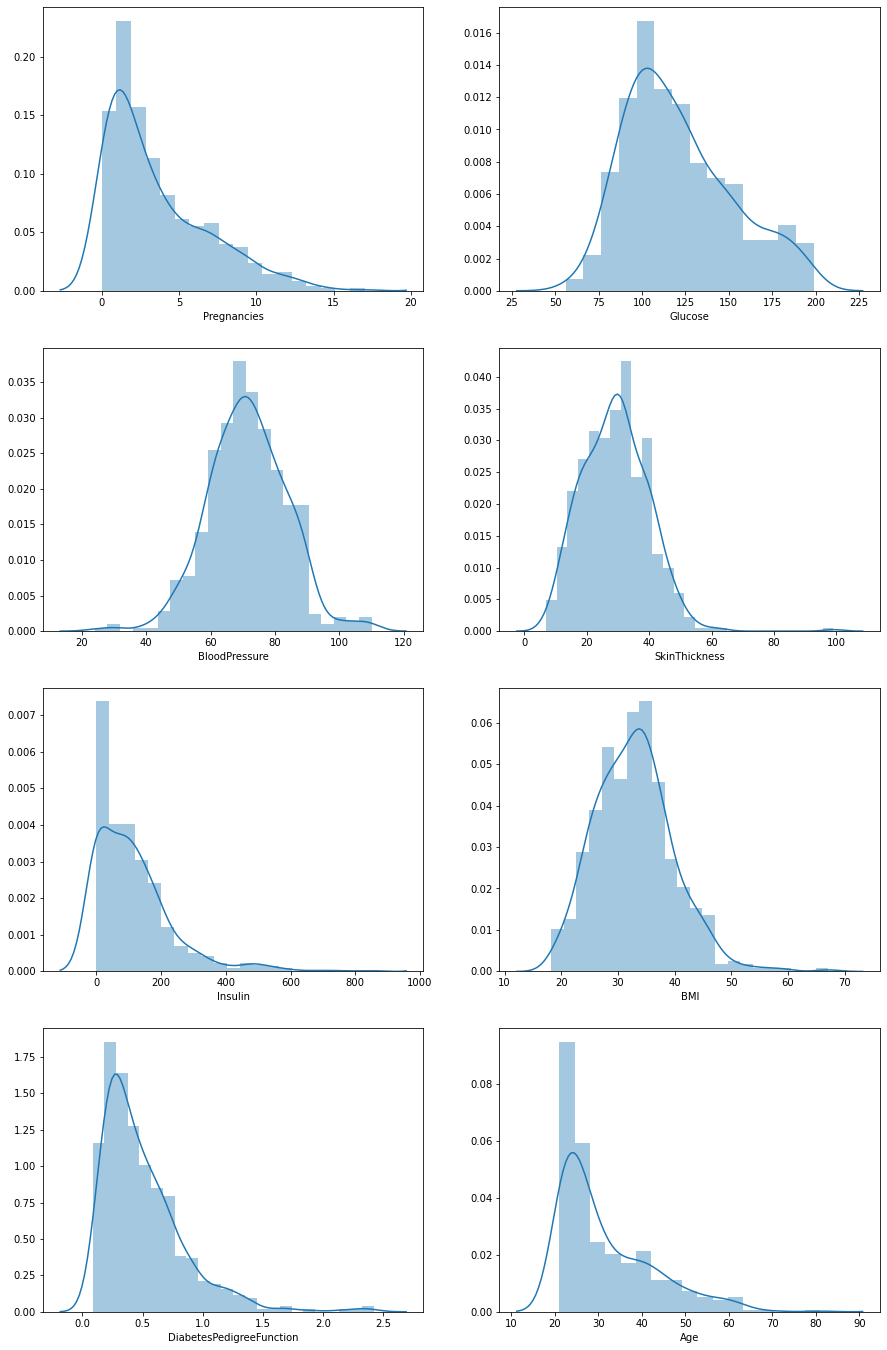

In [99]:
df1 = df.copy()
variables = ['Glucose', 'BloodPressure', 'SkinThickness', 'BMI']
for col in variables:
    df1[df1[col]==0] = np.nan
df1.dropna(axis=0)

variables = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']
fig, axs = plt.subplots(4, 2, figsize=(15, 24))

for ax, col in zip(axs.flatten(), variables):
    sns.distplot(df1[col], ax=ax)

Se observa que las variables _**Glucose**_ y _**BloodPressure**_ se asemejan a la gausiana pero con un sesgo mínimo. En el caso de **_BMI_**, **_Pregnancies_**, **_SkinThickness_**, **_DiabetesPedigreeFunction_** y **_Age_**, una de las razones que estás gráficas estén sesgadas es la poca cantidad de muestras del estudio.

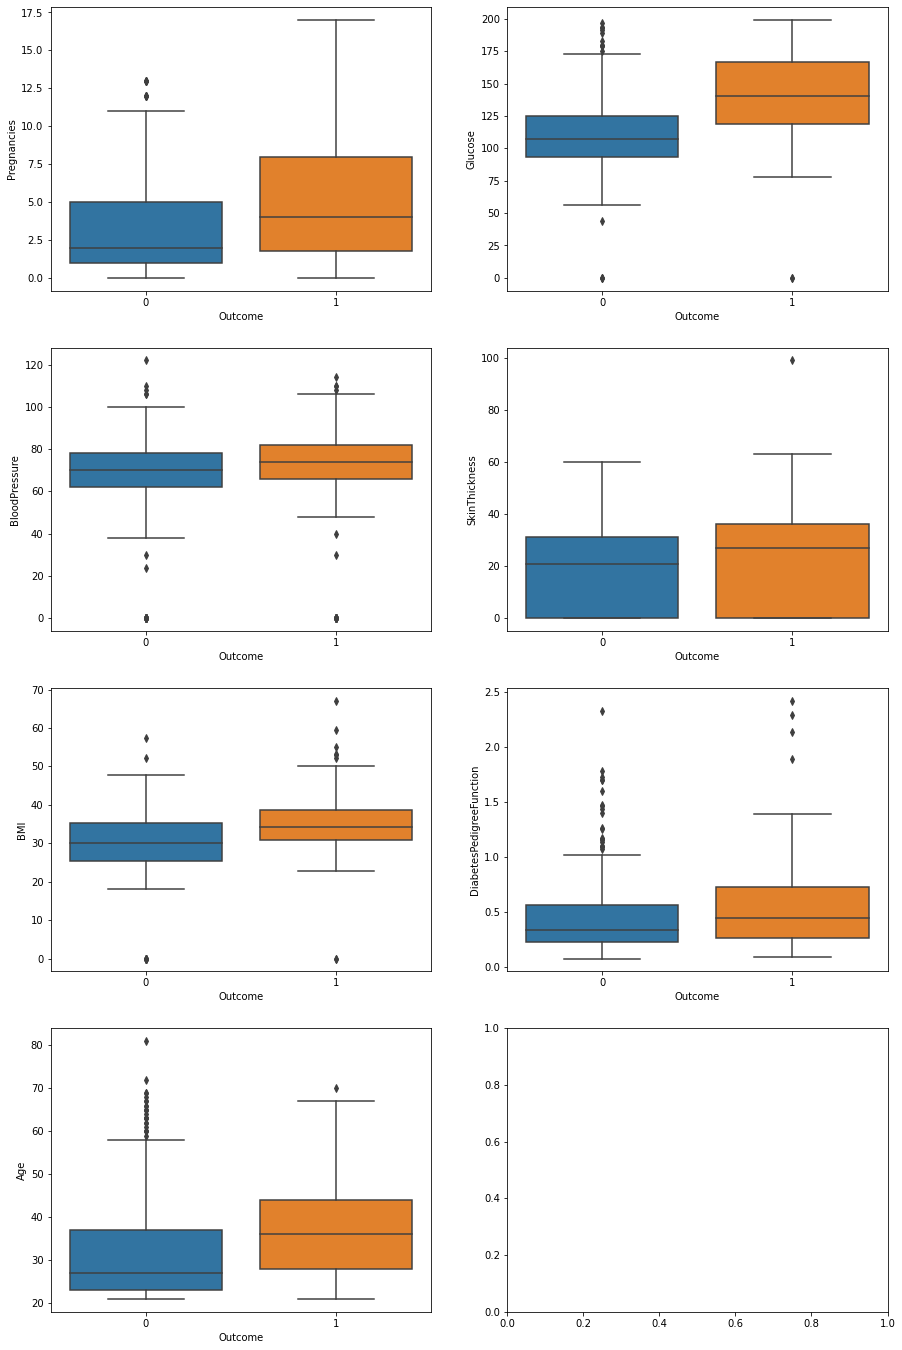

In [100]:
df1 = df.copy()
variables = ['Glucose', 'BloodPressure', 'SkinThickness', 'BMI']
for col in variables:
    df1[df1[col]==0] = np.nan
df1.dropna(axis=0)

variables = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'BMI', 'DiabetesPedigreeFunction', 'Age']
fig, axs = plt.subplots(4, 2, figsize=(15, 24))

for ax, col in zip(axs.flatten()[:7], variables):
    sns.boxplot(x='Outcome', y=col, data=df, ax=ax)

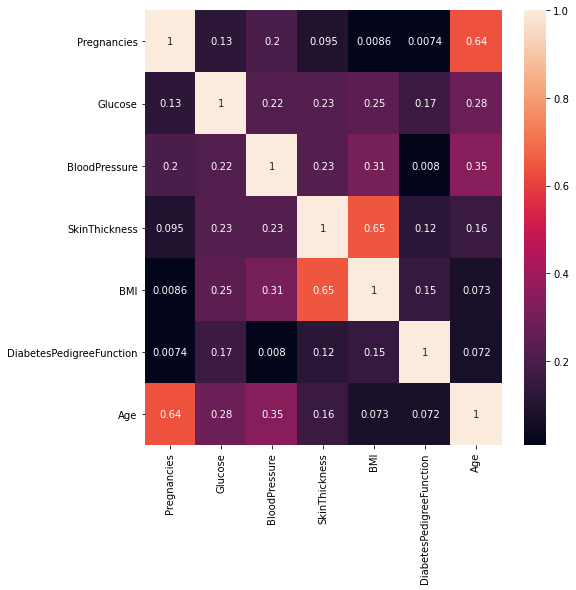

In [107]:
corr = df1[['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'BMI', 'DiabetesPedigreeFunction', 'Age']].corr()
plt.figure(figsize=(8, 8))
sns.heatmap(np.round(corr, 4), annot=True)